# ASR

---

- Sources

  - (`A1`) [How to build domain specific automatic speech recognition (ASR) models](https://developer.nvidia.com/blog/how-to-build-domain-specific-automatic-speech-recognition-models-on-gpus/)

### WER

For more info refer to source `A1`

```python
# WER metric is based on `edit-distance` - a spelling correction technique.
word_error_rate = (substitutions + insertions + deletions) / spoken_words
```

### CTC

> A simple way of getting predictions like this would be to apply a bidirectional RNN to the audio input, apply `softmax` over each time step's output, and then take the token with the ***highest probability***. The method of always taking the best token at each time step is called `greedy decoding`, or `max decoding`.

- Calculating the **Loss**

> To calculate our loss for backprop, we would like to know the log probability of the model producing the correct transcript, `log(Pr(transcript|audio))`. We can get the log probability of a single intermediate output sequence (e.g. BOO-OOO--KK) by summing over the log probabilities we get from each token's softmax value, but note that the resulting sum is different from the log probability of the transcript itself (BOOK). This is because there are multiple possible output sequences of the same length that can be collapsed to get the same transcript (e.g. BBO--OO-KKK also results in BOOK), and so we need to marginalize over every valid sequence of length T that collapses to the transcript.

In [1]:
data_dir = 'AN4-Dataset'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
data_dir = os.path.abspath(data_dir)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    os.mkdir(data_dir + '/an4/')
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Finished conversion.
******


In [3]:
import IPython.display as ipd
from pathlib import Path
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')

import numpy as np
import librosa
import librosa.display

In [4]:
mgah_path = Path('AN4-Dataset/an4/wav/an4_clstk/mgah').absolute()
mgah_files = sorted(p for p in mgah_path.iterdir() if p.suffix == '.wav')
example_file = next(filter(lambda p: p.name.endswith('cen2-mgah-b.wav'), mgah_files))
audio, sample_rate = librosa.load(example_file.as_posix())
ipd.Audio(example_file.as_posix(), rate=sample_rate)

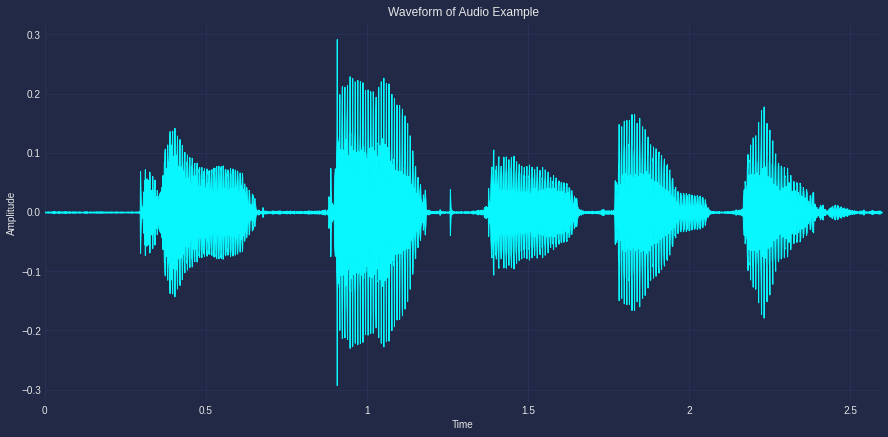

In [5]:
# plt the example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')
_ = librosa.display.waveplot(audio)
plt.show()

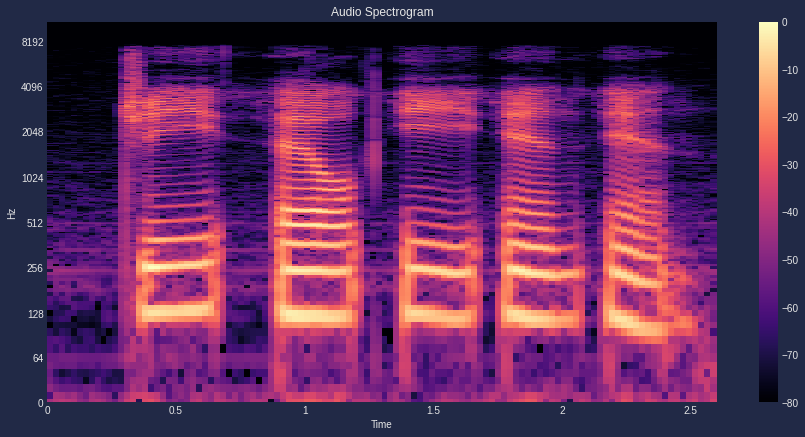

In [6]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels
# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');
plt.show()

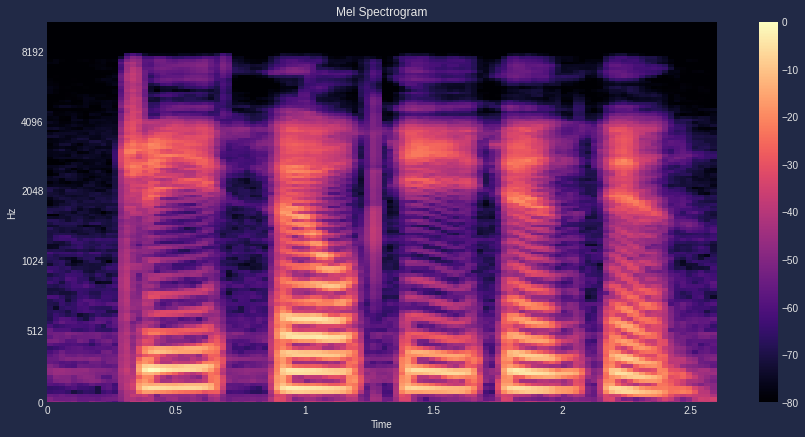

In [7]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram')
plt.show()

#### NEMO (core package)

The `nemo.collections.asr` module is a collections contains complete `ASR` models and building blocks (modules) for `ASR`

- Installing NEMO; change the the branch if needed (See repo for current releases). 

> **NOTE** remove `--no-deps` if you are in a fresh enviroment (specific to NEMO) or you know what you are doing. Removing it could break currently installed packages.

```
!pip install --no-deps hydra-core --upgrade
!pip install --no-deps omegaconf
!pip install --no-deps g2p_en
```

```ipython
BRANCH = 'v1.0.0b3'
!python -m pip install --no-deps git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
```

In [8]:
from nemo import __version__; print(__version__)

1.0.0b3


In [9]:
import warnings
warnings.filterwarnings('ignore')

import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2021-01-15 23:45:40 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-01-15 23:45:40 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-01-15 23:45:40 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-01-15 23:45:40 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-01-15 23:45:40 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

In [10]:
# The following will download the pre-trained QuartzNet15x5
# model from NVIDIA's NGC cloud and instantiate it for you.

model_name = "QuartzNet15x5Base-En"
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name)

[NeMo I 2021-01-15 23:45:43 cloud:56] Found existing object /home/ego/.cache/torch/NeMo/NeMo_1.0.0b3/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-01-15 23:45:43 cloud:62] Re-using file from: /home/ego/.cache/torch/NeMo/NeMo_1.0.0b3/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2021-01-15 23:45:43 common:399] Instantiating model from pre-trained checkpoint
[NeMo I 2021-01-15 23:45:44 features:241] PADDING: 16
[NeMo I 2021-01-15 23:45:44 features:258] STFT using torch
[NeMo I 2021-01-15 23:45:48 modelPT:257] Model EncDecCTCModel was successfully restored from /home/ego/.cache/torch/NeMo/NeMo_1.0.0b3/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


In [11]:
quartznet.device

device(type='cuda', index=0)

In [12]:
n = 2
for file in mgah_files[:n]:
    transcript = quartznet.transcribe(paths2audio_files=[file.as_posix()])
    print("Audio in {} recognized as: {}".format(file.name, transcript))

Audio in an196-mgah-b.wav recognized as: ['inter seventy one']
Audio in an197-mgah-b.wav recognized as: ['inter four twenty one']


#### Training from Scratch

To train from scratch, you need to prepare your training data in the right format and specify your models architecture.

#### Creating Data Manifests

The first thing we need to do now is to create manifests for our training and evaluation data, which will contain the metadata of our audio files. NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

- Here's an example of what one line in a NeMo-compatible manifest might look like:

```python
{
    "audio_filepath": "path/to/audio.wav",
    "duration": 3.45,
    "text": "this is a nemo tutorial"
}
```

In [13]:
from typing import Tuple
import re
import json
from librosa.core import get_duration

SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
INPUT = re.compile(r"(([a-z0-9]+)-([a-z0-9]+)-\w{1})")


def manifest_format(line: str) -> Tuple[str, str]:
    tokens = INPUT.split(line.lower())
    transcript, file_id, _, parent_dir = tokens[:len(tokens)-1]
    transcript = (transcript.replace('(', '')
                  .replace(SOS_TOKEN, '')
                  .replace(EOS_TOKEN, '')
                  .strip())
    audio_file = f'{parent_dir}/{file_id.strip()}.wav'
    return transcript, audio_file


def build_manifest(transcripts: Path, manifest: Path, wav_dir: Path):
    assert all(
        isinstance(x, Path) for x in (transcripts, manifest, wav_dir)
    )
    with transcripts.open('r') as reader:
        with manifest.open('w') as writer:
            for line in reader:
                transcript, audio_file = manifest_format(line)
                audio_path = wav_dir.joinpath(audio_file)
                assert audio_path.is_file()
                duration = get_duration(filename=audio_path.as_posix())
                # Write the metadata to the manifest:
                metadata = {
                    'audio_filepath': audio_path.as_posix(),
                    'duration': duration,
                    'text': transcript
                }
                json.dump(metadata, writer)
                writer.write('\n')

In [14]:
an4_root_dir = Path(data_dir).joinpath('an4/')
an4_etc_dir = an4_root_dir.joinpath('etc/')

# Paths to the train and test transcription files.
train_transcripts = an4_etc_dir.joinpath('an4_train.transcription')
test_transcripts = an4_etc_dir.joinpath('an4_test.transcription')

# Paths to the train and test directories holding (WAV) audio files.
train_wav_path = an4_root_dir.joinpath('wav/an4_clstk')
test_wav_path = an4_root_dir.joinpath('wav/an4test_clstk')

# Paths for the new train and test manifest files.
train_manifest = an4_root_dir.joinpath('train_manifest.json')
test_manifest = an4_root_dir.joinpath('test_manifest.json')

# Quick inspection/test before building both manifest files.
for p in [train_transcripts, test_transcripts, train_wav_path, test_wav_path]:
    print("exist? {} | directory? {} | file? {}\t{}".format(
        p.exists(), p.is_dir(), p.is_file(), p.name))

exist? True | directory? False | file? True	an4_train.transcription
exist? True | directory? False | file? True	an4_test.transcription
exist? True | directory? True | file? False	an4_clstk
exist? True | directory? True | file? False	an4test_clstk


In [15]:
override = False
print("******")
if override or not train_manifest.exists() or not train_manifest.is_file():
    build_manifest(train_transcripts, train_manifest, train_wav_path)
    print("Training manifest created.")
if override or not test_manifest.exists() or not test_manifest.is_file():
    build_manifest(test_transcripts, test_manifest, test_wav_path)
    print("Test manifest created.")
print("***Done***")

******
***Done***


#### Specifying Our Model with a YAML Config File

The config file contains the parameters for training a Jasper_4x1 model, with K=4 blocks of single (R=1) sub-blocks and a greedy CTC decoder.

- If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled encoder, with a field called jasper that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:

```yaml
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```

> The first member of the list corresponds to the first block in the Jasper architecture diagram, which appears regardless of K and R. Next, we have four entries that correspond to the K=4 blocks, and each has repeat: 1 since we are using R=1. These are followed by two more entries for the blocks that appear at the end of our Jasper model before the CTC loss.

There are also some entries at the top of the file that specify how we will handle training (train_ds) and validation (validation_ds) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

---

#### Training with PyTorch Lightning

> NeMo models and modules can be used in any PyTorch code where `torch.nn.Module` is expected.

- However, NeMo's models are based on PytorchLightning's LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs

In [16]:
# Uncomment all or any of the following commands for the config we'll use in this example:
# BRANCH = 'v1.0.0b3'
# !mkdir configs
# !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

In [17]:
import rich
from ruamel.yaml import YAML

In [18]:
config = Path('configs/config.yaml')
yaml = YAML(typ='safe')
with config.open('r') as cfg_file:
    params = yaml.load(cfg_file)

# Update the parameters pointing the manifest files(2) created in the last section.
params['model']['train_ds']['manifest_filepath'] = train_manifest.as_posix()
params['model']['validation_ds']['manifest_filepath'] = test_manifest.as_posix()

rich.print(params.keys())

In [19]:
from omegaconf import DictConfig
import pytorch_lightning as pl
from nemo.collections.asr.models import EncDecCTCModel

In [20]:
# Instatiate a new ASR model based on the config.yaml file with one line!
trainer = pl.Trainer(gpus=1, max_epochs=50)
cfg = DictConfig(params['model'])
asr_model = EncDecCTCModel(cfg=cfg, trainer=trainer)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-01-15 23:45:49 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-01-15 23:45:49 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-01-15 23:45:49 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-01-15 23:45:49 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-01-15 23:45:49 features:241] PADDING: 16
[NeMo I 2021-01-15 23:45:49 features:258] STFT using torch


> Finally, we start training our ASR model!

In [21]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [22]:
trainer.fit(asr_model)

[NeMo I 2021-01-15 23:45:55 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2021-01-15 23:45:55 lr_scheduler:562] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f288cb1ae10>" 
    will be used during training (effective maximum steps = 1500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1500
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1.2 M 
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params


[NeMo I 2021-01-15 23:45:55 wer:159] 
    
[NeMo I 2021-01-15 23:45:55 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:45:55 wer:161] decoded  :z
[NeMo I 2021-01-15 23:45:56 wer:159] 
    
[NeMo I 2021-01-15 23:45:56 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:45:56 wer:161] decoded  :z


[NeMo I 2021-01-15 23:46:01 wer:159] 
    
[NeMo I 2021-01-15 23:46:01 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:01 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:01 wer:159] 
    
[NeMo I 2021-01-15 23:46:01 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:01 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:01 wer:159] 
    
[NeMo I 2021-01-15 23:46:01 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:01 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:01 wer:159] 
    
[NeMo I 2021-01-15 23:46:01 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:01 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:01 wer:159] 
    
[NeMo I 2021-01-15 23:46:01 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:01 wer:161] decoded  :


[NeMo I 2021-01-15 23:46:06 wer:159] 
    
[NeMo I 2021-01-15 23:46:06 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:06 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:06 wer:159] 
    
[NeMo I 2021-01-15 23:46:06 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:06 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:06 wer:159] 
    
[NeMo I 2021-01-15 23:46:06 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:06 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:06 wer:159] 
    
[NeMo I 2021-01-15 23:46:06 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:06 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:06 wer:159] 
    
[NeMo I 2021-01-15 23:46:06 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:06 wer:161] decoded  :


[NeMo I 2021-01-15 23:46:11 wer:159] 
    
[NeMo I 2021-01-15 23:46:11 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:11 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:11 wer:159] 
    
[NeMo I 2021-01-15 23:46:11 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:11 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:11 wer:159] 
    
[NeMo I 2021-01-15 23:46:11 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:11 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:11 wer:159] 
    
[NeMo I 2021-01-15 23:46:11 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:11 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:11 wer:159] 
    
[NeMo I 2021-01-15 23:46:11 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:11 wer:161] decoded  :


[NeMo I 2021-01-15 23:46:16 wer:159] 
    
[NeMo I 2021-01-15 23:46:16 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:16 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:16 wer:159] 
    
[NeMo I 2021-01-15 23:46:16 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:16 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:16 wer:159] 
    
[NeMo I 2021-01-15 23:46:16 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:16 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:16 wer:159] 
    
[NeMo I 2021-01-15 23:46:16 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:16 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:16 wer:159] 
    
[NeMo I 2021-01-15 23:46:16 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:16 wer:161] decoded  :


[NeMo I 2021-01-15 23:46:21 wer:159] 
    
[NeMo I 2021-01-15 23:46:21 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:21 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:21 wer:159] 
    
[NeMo I 2021-01-15 23:46:21 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:21 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:21 wer:159] 
    
[NeMo I 2021-01-15 23:46:21 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:21 wer:161] decoded  : 
[NeMo I 2021-01-15 23:46:21 wer:159] 
    
[NeMo I 2021-01-15 23:46:21 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:21 wer:161] decoded  :
[NeMo I 2021-01-15 23:46:21 wer:159] 
    
[NeMo I 2021-01-15 23:46:21 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:21 wer:161] decoded  :  


[NeMo I 2021-01-15 23:46:26 wer:159] 
    
[NeMo I 2021-01-15 23:46:26 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:26 wer:161] decoded  :      
[NeMo I 2021-01-15 23:46:26 wer:159] 
    
[NeMo I 2021-01-15 23:46:26 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:26 wer:161] decoded  :  
[NeMo I 2021-01-15 23:46:26 wer:159] 
    
[NeMo I 2021-01-15 23:46:26 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:26 wer:161] decoded  :  s
[NeMo I 2021-01-15 23:46:26 wer:159] 
    
[NeMo I 2021-01-15 23:46:26 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:26 wer:161] decoded  :  s
[NeMo I 2021-01-15 23:46:26 wer:159] 
    
[NeMo I 2021-01-15 23:46:26 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:26 wer:161] decoded  :  t t s   t


[NeMo I 2021-01-15 23:46:31 wer:159] 
    
[NeMo I 2021-01-15 23:46:31 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:31 wer:161] decoded  :     
[NeMo I 2021-01-15 23:46:31 wer:159] 
    
[NeMo I 2021-01-15 23:46:31 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:31 wer:161] decoded  : e  
[NeMo I 2021-01-15 23:46:31 wer:159] 
    
[NeMo I 2021-01-15 23:46:31 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:31 wer:161] decoded  :e t s s
[NeMo I 2021-01-15 23:46:31 wer:159] 
    
[NeMo I 2021-01-15 23:46:31 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:31 wer:161] decoded  :e e  s
[NeMo I 2021-01-15 23:46:31 wer:159] 
    
[NeMo I 2021-01-15 23:46:31 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:31 wer:161] decoded  :nn ttw s thne f t


[NeMo I 2021-01-15 23:46:36 wer:159] 
    
[NeMo I 2021-01-15 23:46:36 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:36 wer:161] decoded  :t   e 
[NeMo I 2021-01-15 23:46:36 wer:159] 
    
[NeMo I 2021-01-15 23:46:36 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:36 wer:161] decoded  : e f 
[NeMo I 2021-01-15 23:46:36 wer:159] 
    
[NeMo I 2021-01-15 23:46:36 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:36 wer:161] decoded  :r tn tn sixt s
[NeMo I 2021-01-15 23:46:36 wer:159] 
    
[NeMo I 2021-01-15 23:46:36 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:36 wer:161] decoded  : e r s
[NeMo I 2021-01-15 23:46:36 wer:159] 
    
[NeMo I 2021-01-15 23:46:36 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:36 wer:161] decoded  :for one ttwofsix tfhfrne furtw


[NeMo I 2021-01-15 23:46:40 wer:159] 
    
[NeMo I 2021-01-15 23:46:40 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:40 wer:161] decoded  :t g   he n
[NeMo I 2021-01-15 23:46:40 wer:159] 
    
[NeMo I 2021-01-15 23:46:40 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:40 wer:161] decoded  :et t 
[NeMo I 2021-01-15 23:46:41 wer:159] 
    
[NeMo I 2021-01-15 23:46:41 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:41 wer:161] decoded  :r enone tw sixtsv
[NeMo I 2021-01-15 23:46:41 wer:159] 
    
[NeMo I 2021-01-15 23:46:41 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:41 wer:161] decoded  : ne r s
[NeMo I 2021-01-15 23:46:41 wer:159] 
    
[NeMo I 2021-01-15 23:46:41 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:41 wer:161] decoded  :for one tetwoosix ehtfor one four two


[NeMo I 2021-01-15 23:46:45 wer:159] 
    
[NeMo I 2021-01-15 23:46:45 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:45 wer:161] decoded  :notg en e he ne
[NeMo I 2021-01-15 23:46:45 wer:159] 
    
[NeMo I 2021-01-15 23:46:45 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:45 wer:161] decoded  :en e ne ti n
[NeMo I 2021-01-15 23:46:46 wer:159] 
    
[NeMo I 2021-01-15 23:46:46 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:46 wer:161] decoded  :rsene oine teene sixty sve
[NeMo I 2021-01-15 23:46:46 wer:159] 
    
[NeMo I 2021-01-15 23:46:46 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:46 wer:161] decoded  :n  e r s
[NeMo I 2021-01-15 23:46:46 wer:159] 
    
[NeMo I 2021-01-15 23:46:46 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:46 wer:161] decoded  :for onetwentwofsiexteeightfor one fooretwo


[NeMo I 2021-01-15 23:46:50 wer:159] 
    
[NeMo I 2021-01-15 23:46:50 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:50 wer:161] decoded  :t g    n
[NeMo I 2021-01-15 23:46:50 wer:159] 
    
[NeMo I 2021-01-15 23:46:50 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:50 wer:161] decoded  : e  t 
[NeMo I 2021-01-15 23:46:50 wer:159] 
    
[NeMo I 2021-01-15 23:46:50 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:50 wer:161] decoded  :r ennne t sixt sev
[NeMo I 2021-01-15 23:46:50 wer:159] 
    
[NeMo I 2021-01-15 23:46:50 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:50 wer:161] decoded  :   r s
[NeMo I 2021-01-15 23:46:50 wer:159] 
    
[NeMo I 2021-01-15 23:46:50 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:50 wer:161] decoded  :for one twetwo sx thtfr one fur two


[NeMo I 2021-01-15 23:46:55 wer:159] 
    
[NeMo I 2021-01-15 23:46:55 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:46:55 wer:161] decoded  :out g n e fh n
[NeMo I 2021-01-15 23:46:55 wer:159] 
    
[NeMo I 2021-01-15 23:46:55 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:46:55 wer:161] decoded  :en e ht fhr 
[NeMo I 2021-01-15 23:46:55 wer:159] 
    
[NeMo I 2021-01-15 23:46:55 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:46:55 wer:161] decoded  :r h sevene onine ten sixt sv
[NeMo I 2021-01-15 23:46:55 wer:159] 
    
[NeMo I 2021-01-15 23:46:55 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:46:55 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:46:55 wer:159] 
    
[NeMo I 2021-01-15 23:46:55 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:46:55 wer:161] decoded  :for one tseo two six tihtfor one four two


[NeMo I 2021-01-15 23:47:00 wer:159] 
    
[NeMo I 2021-01-15 23:47:00 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:00 wer:161] decoded  : tg   h n
[NeMo I 2021-01-15 23:47:00 wer:159] 
    
[NeMo I 2021-01-15 23:47:00 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:00 wer:161] decoded  :n e   
[NeMo I 2021-01-15 23:47:00 wer:159] 
    
[NeMo I 2021-01-15 23:47:00 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:00 wer:161] decoded  :rve ine t sixt s
[NeMo I 2021-01-15 23:47:00 wer:159] 
    
[NeMo I 2021-01-15 23:47:00 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:00 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:00 wer:159] 
    
[NeMo I 2021-01-15 23:47:00 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:00 wer:161] decoded  :for one two two six hfor one four two


[NeMo I 2021-01-15 23:47:05 wer:159] 
    
[NeMo I 2021-01-15 23:47:05 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:05 wer:161] decoded  :rubut g   fhe ne
[NeMo I 2021-01-15 23:47:05 wer:159] 
    
[NeMo I 2021-01-15 23:47:05 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:05 wer:161] decoded  :en e  her 
[NeMo I 2021-01-15 23:47:05 wer:159] 
    
[NeMo I 2021-01-15 23:47:05 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:05 wer:161] decoded  :rh sen oine ten sixty sev
[NeMo I 2021-01-15 23:47:05 wer:159] 
    
[NeMo I 2021-01-15 23:47:05 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:05 wer:161] decoded  : o e r s
[NeMo I 2021-01-15 23:47:05 wer:159] 
    
[NeMo I 2021-01-15 23:47:05 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:05 wer:161] decoded  :four one twe two six eightfor one four two


[NeMo I 2021-01-15 23:47:10 wer:159] 
    
[NeMo I 2021-01-15 23:47:10 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:10 wer:161] decoded  :bout g n  fh n
[NeMo I 2021-01-15 23:47:10 wer:159] 
    
[NeMo I 2021-01-15 23:47:10 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:10 wer:161] decoded  :e n e  sie 
[NeMo I 2021-01-15 23:47:10 wer:159] 
    
[NeMo I 2021-01-15 23:47:10 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:10 wer:161] decoded  :urhsein nine t sixty sv
[NeMo I 2021-01-15 23:47:10 wer:159] 
    
[NeMo I 2021-01-15 23:47:10 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:10 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:10 wer:159] 
    
[NeMo I 2021-01-15 23:47:10 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:10 wer:161] decoded  : four one twe two six ightfour one four two


[NeMo I 2021-01-15 23:47:15 wer:159] 
    
[NeMo I 2021-01-15 23:47:15 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:15 wer:161] decoded  :bot t en e fthre nie
[NeMo I 2021-01-15 23:47:15 wer:159] 
    
[NeMo I 2021-01-15 23:47:15 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:15 wer:161] decoded  :e on e ine thie n
[NeMo I 2021-01-15 23:47:15 wer:159] 
    
[NeMo I 2021-01-15 23:47:15 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:15 wer:161] decoded  :rhseineonineten sixty seve
[NeMo I 2021-01-15 23:47:15 wer:159] 
    
[NeMo I 2021-01-15 23:47:15 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:15 wer:161] decoded  :n ny e r s
[NeMo I 2021-01-15 23:47:15 wer:159] 
    
[NeMo I 2021-01-15 23:47:15 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:15 wer:161] decoded  :for one teontwo six teightfor one foor two


[NeMo I 2021-01-15 23:47:20 wer:159] 
    
[NeMo I 2021-01-15 23:47:20 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:20 wer:161] decoded  :ubout g n e fh oe
[NeMo I 2021-01-15 23:47:20 wer:159] 
    
[NeMo I 2021-01-15 23:47:20 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:20 wer:161] decoded  :e n e  tie n
[NeMo I 2021-01-15 23:47:20 wer:159] 
    
[NeMo I 2021-01-15 23:47:20 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:20 wer:161] decoded  :orthseveine oneteen sixty sve
[NeMo I 2021-01-15 23:47:20 wer:159] 
    
[NeMo I 2021-01-15 23:47:20 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:20 wer:161] decoded  :n oy e r s
[NeMo I 2021-01-15 23:47:20 wer:159] 
    
[NeMo I 2021-01-15 23:47:20 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:20 wer:161] decoded  :four one tweotwo swiex twghtfor one for two


[NeMo I 2021-01-15 23:47:25 wer:159] 
    
[NeMo I 2021-01-15 23:47:25 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:25 wer:161] decoded  :ru bot g n e fh ne
[NeMo I 2021-01-15 23:47:25 wer:159] 
    
[NeMo I 2021-01-15 23:47:25 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:25 wer:161] decoded  :e n e  sies n
[NeMo I 2021-01-15 23:47:25 wer:159] 
    
[NeMo I 2021-01-15 23:47:25 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:25 wer:161] decoded  :rhseveive onine ten sixty sev
[NeMo I 2021-01-15 23:47:25 wer:159] 
    
[NeMo I 2021-01-15 23:47:25 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:25 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:25 wer:159] 
    
[NeMo I 2021-01-15 23:47:25 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:25 wer:161] decoded  : four one seo two six ight four one four two


[NeMo I 2021-01-15 23:47:29 wer:159] 
    
[NeMo I 2021-01-15 23:47:29 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:29 wer:161] decoded  :blt g n e fh ne
[NeMo I 2021-01-15 23:47:30 wer:159] 
    
[NeMo I 2021-01-15 23:47:30 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:30 wer:161] decoded  :e n e  ir 
[NeMo I 2021-01-15 23:47:30 wer:159] 
    
[NeMo I 2021-01-15 23:47:30 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:30 wer:161] decoded  :orhseee nine ten sixty so
[NeMo I 2021-01-15 23:47:30 wer:159] 
    
[NeMo I 2021-01-15 23:47:30 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:30 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:30 wer:159] 
    
[NeMo I 2021-01-15 23:47:30 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:30 wer:161] decoded  :for one setwo six ht for one four tw


[NeMo I 2021-01-15 23:47:34 wer:159] 
    
[NeMo I 2021-01-15 23:47:34 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:34 wer:161] decoded  :bout g  e fth 
[NeMo I 2021-01-15 23:47:34 wer:159] 
    
[NeMo I 2021-01-15 23:47:34 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:34 wer:161] decoded  :e n e  fir 
[NeMo I 2021-01-15 23:47:34 wer:159] 
    
[NeMo I 2021-01-15 23:47:34 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:34 wer:161] decoded  :orh seen nine ten sixty so
[NeMo I 2021-01-15 23:47:34 wer:159] 
    
[NeMo I 2021-01-15 23:47:34 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:34 wer:161] decoded  : o e r s
[NeMo I 2021-01-15 23:47:34 wer:159] 
    
[NeMo I 2021-01-15 23:47:34 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:34 wer:161] decoded  :for one twoo two six ht for one foor two


[NeMo I 2021-01-15 23:47:39 wer:159] 
    
[NeMo I 2021-01-15 23:47:39 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:39 wer:161] decoded  :rubout g n e fthe nye
[NeMo I 2021-01-15 23:47:39 wer:159] 
    
[NeMo I 2021-01-15 23:47:39 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:39 wer:161] decoded  :e n e e sie n
[NeMo I 2021-01-15 23:47:39 wer:159] 
    
[NeMo I 2021-01-15 23:47:39 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:39 wer:161] decoded  :rx seine nine ten sixty sev
[NeMo I 2021-01-15 23:47:39 wer:159] 
    
[NeMo I 2021-01-15 23:47:39 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:39 wer:161] decoded  :en y e r s
[NeMo I 2021-01-15 23:47:39 wer:159] 
    
[NeMo I 2021-01-15 23:47:39 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:39 wer:161] decoded  :four one teen two six eightfour one four two


[NeMo I 2021-01-15 23:47:44 wer:159] 
    
[NeMo I 2021-01-15 23:47:44 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:44 wer:161] decoded  :boutg n e th 
[NeMo I 2021-01-15 23:47:44 wer:159] 
    
[NeMo I 2021-01-15 23:47:44 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:44 wer:161] decoded  :e n e  si 
[NeMo I 2021-01-15 23:47:44 wer:159] 
    
[NeMo I 2021-01-15 23:47:44 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:44 wer:161] decoded  :orhseeth ine ten sixty s
[NeMo I 2021-01-15 23:47:44 wer:159] 
    
[NeMo I 2021-01-15 23:47:44 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:44 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:44 wer:159] 
    
[NeMo I 2021-01-15 23:47:44 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:44 wer:161] decoded  : for one t two six tghtfor one for two


[NeMo I 2021-01-15 23:47:48 wer:159] 
    
[NeMo I 2021-01-15 23:47:48 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:48 wer:161] decoded  :bout g n e the nie
[NeMo I 2021-01-15 23:47:49 wer:159] 
    
[NeMo I 2021-01-15 23:47:49 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:49 wer:161] decoded  :ee ne  sie n
[NeMo I 2021-01-15 23:47:49 wer:159] 
    
[NeMo I 2021-01-15 23:47:49 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:49 wer:161] decoded  :orxseine onineten sixty seve
[NeMo I 2021-01-15 23:47:49 wer:159] 
    
[NeMo I 2021-01-15 23:47:49 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:49 wer:161] decoded  :n y e r s
[NeMo I 2021-01-15 23:47:49 wer:159] 
    
[NeMo I 2021-01-15 23:47:49 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:49 wer:161] decoded  :four one seo two six teightfour one four tw


[NeMo I 2021-01-15 23:47:53 wer:159] 
    
[NeMo I 2021-01-15 23:47:53 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:53 wer:161] decoded  :bolt g n e fth n
[NeMo I 2021-01-15 23:47:53 wer:159] 
    
[NeMo I 2021-01-15 23:47:53 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:53 wer:161] decoded  : n e  si 
[NeMo I 2021-01-15 23:47:53 wer:159] 
    
[NeMo I 2021-01-15 23:47:53 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:53 wer:161] decoded  :rhsevei nine ten sixty so
[NeMo I 2021-01-15 23:47:53 wer:159] 
    
[NeMo I 2021-01-15 23:47:53 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:53 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:47:53 wer:159] 
    
[NeMo I 2021-01-15 23:47:53 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:53 wer:161] decoded  :four one se two six ehtfor one four tw


[NeMo I 2021-01-15 23:47:58 wer:159] 
    
[NeMo I 2021-01-15 23:47:58 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:47:58 wer:161] decoded  :rbout g n e th nie
[NeMo I 2021-01-15 23:47:58 wer:159] 
    
[NeMo I 2021-01-15 23:47:58 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:47:58 wer:161] decoded  : n e  sie n
[NeMo I 2021-01-15 23:47:58 wer:159] 
    
[NeMo I 2021-01-15 23:47:58 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:47:58 wer:161] decoded  :rh seine nine ten sixty s
[NeMo I 2021-01-15 23:47:58 wer:159] 
    
[NeMo I 2021-01-15 23:47:58 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:47:58 wer:161] decoded  : o e r s
[NeMo I 2021-01-15 23:47:58 wer:159] 
    
[NeMo I 2021-01-15 23:47:58 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:47:58 wer:161] decoded  : four one s two six ight four one four tw


[NeMo I 2021-01-15 23:48:03 wer:159] 
    
[NeMo I 2021-01-15 23:48:03 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:03 wer:161] decoded  :but g  e fth ni
[NeMo I 2021-01-15 23:48:03 wer:159] 
    
[NeMo I 2021-01-15 23:48:03 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:03 wer:161] decoded  :e n e  si n
[NeMo I 2021-01-15 23:48:03 wer:159] 
    
[NeMo I 2021-01-15 23:48:03 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:03 wer:161] decoded  :rhsei nineten sixty sev
[NeMo I 2021-01-15 23:48:03 wer:159] 
    
[NeMo I 2021-01-15 23:48:03 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:03 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:48:03 wer:159] 
    
[NeMo I 2021-01-15 23:48:03 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:03 wer:161] decoded  :four one se two six eight four one four tw


[NeMo I 2021-01-15 23:48:07 wer:159] 
    
[NeMo I 2021-01-15 23:48:07 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:07 wer:161] decoded  :rboutg  e th ni
[NeMo I 2021-01-15 23:48:07 wer:159] 
    
[NeMo I 2021-01-15 23:48:07 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:07 wer:161] decoded  :e n e  sie n
[NeMo I 2021-01-15 23:48:07 wer:159] 
    
[NeMo I 2021-01-15 23:48:07 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:07 wer:161] decoded  :rhseveh nineten sixty sv
[NeMo I 2021-01-15 23:48:07 wer:159] 
    
[NeMo I 2021-01-15 23:48:07 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:07 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:48:07 wer:159] 
    
[NeMo I 2021-01-15 23:48:07 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:07 wer:161] decoded  : for one seo two six ight four one four tw


[NeMo I 2021-01-15 23:48:12 wer:159] 
    
[NeMo I 2021-01-15 23:48:12 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:12 wer:161] decoded  :rbout g  e th ni
[NeMo I 2021-01-15 23:48:12 wer:159] 
    
[NeMo I 2021-01-15 23:48:12 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:12 wer:161] decoded  :e n e  sir on
[NeMo I 2021-01-15 23:48:12 wer:159] 
    
[NeMo I 2021-01-15 23:48:12 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:12 wer:161] decoded  :orhse nineten sixty so
[NeMo I 2021-01-15 23:48:12 wer:159] 
    
[NeMo I 2021-01-15 23:48:12 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:12 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:48:12 wer:159] 
    
[NeMo I 2021-01-15 23:48:12 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:12 wer:161] decoded  : for one s two six ight four one four tw


[NeMo I 2021-01-15 23:48:16 wer:159] 
    
[NeMo I 2021-01-15 23:48:16 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:16 wer:161] decoded  :bt g  e fth i
[NeMo I 2021-01-15 23:48:17 wer:159] 
    
[NeMo I 2021-01-15 23:48:17 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:17 wer:161] decoded  :e n e h si on
[NeMo I 2021-01-15 23:48:17 wer:159] 
    
[NeMo I 2021-01-15 23:48:17 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:17 wer:161] decoded  :rhsevetine nine ten sixty sv
[NeMo I 2021-01-15 23:48:17 wer:159] 
    
[NeMo I 2021-01-15 23:48:17 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:17 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:17 wer:159] 
    
[NeMo I 2021-01-15 23:48:17 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:17 wer:161] decoded  :four one s two six ight four one four tw


[NeMo I 2021-01-15 23:48:21 wer:159] 
    
[NeMo I 2021-01-15 23:48:21 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:21 wer:161] decoded  :rbout g  e fth i
[NeMo I 2021-01-15 23:48:21 wer:159] 
    
[NeMo I 2021-01-15 23:48:21 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:21 wer:161] decoded  :e n e  si 
[NeMo I 2021-01-15 23:48:21 wer:159] 
    
[NeMo I 2021-01-15 23:48:21 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:21 wer:161] decoded  :rhseve e nine ten sixty sv
[NeMo I 2021-01-15 23:48:21 wer:159] 
    
[NeMo I 2021-01-15 23:48:21 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:21 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:48:21 wer:159] 
    
[NeMo I 2021-01-15 23:48:21 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:21 wer:161] decoded  :for one s two six ght for one four tw


[NeMo I 2021-01-15 23:48:26 wer:159] 
    
[NeMo I 2021-01-15 23:48:26 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:26 wer:161] decoded  :boltg m e fth n
[NeMo I 2021-01-15 23:48:26 wer:159] 
    
[NeMo I 2021-01-15 23:48:26 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:26 wer:161] decoded  :e ne  sie o
[NeMo I 2021-01-15 23:48:26 wer:159] 
    
[NeMo I 2021-01-15 23:48:26 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:26 wer:161] decoded  :rhseven nineten sixty sev
[NeMo I 2021-01-15 23:48:26 wer:159] 
    
[NeMo I 2021-01-15 23:48:26 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:26 wer:161] decoded  :  e r s
[NeMo I 2021-01-15 23:48:26 wer:159] 
    
[NeMo I 2021-01-15 23:48:26 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:26 wer:161] decoded  :for one se two six ehfor one four tw


[NeMo I 2021-01-15 23:48:30 wer:159] 
    
[NeMo I 2021-01-15 23:48:30 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:30 wer:161] decoded  :bout g  e fth ni
[NeMo I 2021-01-15 23:48:31 wer:159] 
    
[NeMo I 2021-01-15 23:48:31 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:31 wer:161] decoded  :e n e h sir n
[NeMo I 2021-01-15 23:48:31 wer:159] 
    
[NeMo I 2021-01-15 23:48:31 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:31 wer:161] decoded  :rhsehin nine teen sixty sev
[NeMo I 2021-01-15 23:48:31 wer:159] 
    
[NeMo I 2021-01-15 23:48:31 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:31 wer:161] decoded  : o e r s
[NeMo I 2021-01-15 23:48:31 wer:159] 
    
[NeMo I 2021-01-15 23:48:31 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:31 wer:161] decoded  :for one se two six eight four one four tw


[NeMo I 2021-01-15 23:48:35 wer:159] 
    
[NeMo I 2021-01-15 23:48:35 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:35 wer:161] decoded  :ubout g n e fhth nine
[NeMo I 2021-01-15 23:48:35 wer:159] 
    
[NeMo I 2021-01-15 23:48:35 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:35 wer:161] decoded  :ea n e  sier on
[NeMo I 2021-01-15 23:48:35 wer:159] 
    
[NeMo I 2021-01-15 23:48:35 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:35 wer:161] decoded  :rhsehine nineten sixty sev
[NeMo I 2021-01-15 23:48:35 wer:159] 
    
[NeMo I 2021-01-15 23:48:35 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:35 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:35 wer:159] 
    
[NeMo I 2021-01-15 23:48:35 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:35 wer:161] decoded  :for one tseo two six eight four one four tw


[NeMo I 2021-01-15 23:48:40 wer:159] 
    
[NeMo I 2021-01-15 23:48:40 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:40 wer:161] decoded  :rbout g n e f th nine
[NeMo I 2021-01-15 23:48:40 wer:159] 
    
[NeMo I 2021-01-15 23:48:40 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:40 wer:161] decoded  :e n e  sie n
[NeMo I 2021-01-15 23:48:40 wer:159] 
    
[NeMo I 2021-01-15 23:48:40 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:40 wer:161] decoded  :rhseein nine ten sixty s
[NeMo I 2021-01-15 23:48:40 wer:159] 
    
[NeMo I 2021-01-15 23:48:40 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:40 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:40 wer:159] 
    
[NeMo I 2021-01-15 23:48:40 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:40 wer:161] decoded  : for one s two six eight for one four two


[NeMo I 2021-01-15 23:48:44 wer:159] 
    
[NeMo I 2021-01-15 23:48:44 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:44 wer:161] decoded  :rabout g n e fth nine
[NeMo I 2021-01-15 23:48:45 wer:159] 
    
[NeMo I 2021-01-15 23:48:45 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:45 wer:161] decoded  :ea n e he sie on
[NeMo I 2021-01-15 23:48:45 wer:159] 
    
[NeMo I 2021-01-15 23:48:45 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:45 wer:161] decoded  :rhsevehine nine ten sixty siv
[NeMo I 2021-01-15 23:48:45 wer:159] 
    
[NeMo I 2021-01-15 23:48:45 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:45 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:45 wer:159] 
    
[NeMo I 2021-01-15 23:48:45 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:45 wer:161] decoded  : for one seron two six eight for one four two


[NeMo I 2021-01-15 23:48:49 wer:159] 
    
[NeMo I 2021-01-15 23:48:49 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:49 wer:161] decoded  :bout g  e fth 
[NeMo I 2021-01-15 23:48:49 wer:159] 
    
[NeMo I 2021-01-15 23:48:49 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:49 wer:161] decoded  :e n e  si n
[NeMo I 2021-01-15 23:48:50 wer:159] 
    
[NeMo I 2021-01-15 23:48:50 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:50 wer:161] decoded  :rh seoen nine ten sixty s
[NeMo I 2021-01-15 23:48:50 wer:159] 
    
[NeMo I 2021-01-15 23:48:50 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:50 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:50 wer:159] 
    
[NeMo I 2021-01-15 23:48:50 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:50 wer:161] decoded  :for one so two six ght for one four tw


[NeMo I 2021-01-15 23:48:54 wer:159] 
    
[NeMo I 2021-01-15 23:48:54 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:54 wer:161] decoded  :rubout g n e fth nine
[NeMo I 2021-01-15 23:48:54 wer:159] 
    
[NeMo I 2021-01-15 23:48:54 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:54 wer:161] decoded  :e n e e sie n
[NeMo I 2021-01-15 23:48:54 wer:159] 
    
[NeMo I 2021-01-15 23:48:54 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:54 wer:161] decoded  :rh sevehine nine ten sixty sv
[NeMo I 2021-01-15 23:48:55 wer:159] 
    
[NeMo I 2021-01-15 23:48:55 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:55 wer:161] decoded  : oy e r s
[NeMo I 2021-01-15 23:48:55 wer:159] 
    
[NeMo I 2021-01-15 23:48:55 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:55 wer:161] decoded  : for one sn two six eight for one four tw


[NeMo I 2021-01-15 23:48:59 wer:159] 
    
[NeMo I 2021-01-15 23:48:59 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:48:59 wer:161] decoded  :ubout g n e fth nie
[NeMo I 2021-01-15 23:48:59 wer:159] 
    
[NeMo I 2021-01-15 23:48:59 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:48:59 wer:161] decoded  :e nm e  sie n
[NeMo I 2021-01-15 23:48:59 wer:159] 
    
[NeMo I 2021-01-15 23:48:59 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:48:59 wer:161] decoded  :rhsehin nine ten sixty s
[NeMo I 2021-01-15 23:48:59 wer:159] 
    
[NeMo I 2021-01-15 23:48:59 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:48:59 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:48:59 wer:159] 
    
[NeMo I 2021-01-15 23:48:59 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:48:59 wer:161] decoded  :for one se two six eiight for one four tw


[NeMo I 2021-01-15 23:49:04 wer:159] 
    
[NeMo I 2021-01-15 23:49:04 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:04 wer:161] decoded  :ubout g m e fth ni
[NeMo I 2021-01-15 23:49:04 wer:159] 
    
[NeMo I 2021-01-15 23:49:04 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:04 wer:161] decoded  :e nm e  sie on
[NeMo I 2021-01-15 23:49:04 wer:159] 
    
[NeMo I 2021-01-15 23:49:04 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:04 wer:161] decoded  :rhseveine nine teen sixty sv
[NeMo I 2021-01-15 23:49:04 wer:159] 
    
[NeMo I 2021-01-15 23:49:04 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:04 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:04 wer:159] 
    
[NeMo I 2021-01-15 23:49:04 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:04 wer:161] decoded  :for one seo two six eight four one four tw


[NeMo I 2021-01-15 23:49:08 wer:159] 
    
[NeMo I 2021-01-15 23:49:08 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:08 wer:161] decoded  :rubout g n e fth nine
[NeMo I 2021-01-15 23:49:08 wer:159] 
    
[NeMo I 2021-01-15 23:49:08 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:08 wer:161] decoded  : n e  sie on
[NeMo I 2021-01-15 23:49:08 wer:159] 
    
[NeMo I 2021-01-15 23:49:08 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:08 wer:161] decoded  :rhsehn nineteen sixty sv
[NeMo I 2021-01-15 23:49:09 wer:159] 
    
[NeMo I 2021-01-15 23:49:09 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:09 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:09 wer:159] 
    
[NeMo I 2021-01-15 23:49:09 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:09 wer:161] decoded  :for one seo two six teight four one four tw


[NeMo I 2021-01-15 23:49:13 wer:159] 
    
[NeMo I 2021-01-15 23:49:13 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:13 wer:161] decoded  :ubout g m e f h ie
[NeMo I 2021-01-15 23:49:13 wer:159] 
    
[NeMo I 2021-01-15 23:49:13 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:13 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:13 wer:159] 
    
[NeMo I 2021-01-15 23:49:13 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:13 wer:161] decoded  :rhsevein nine teen sixty sv
[NeMo I 2021-01-15 23:49:13 wer:159] 
    
[NeMo I 2021-01-15 23:49:13 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:13 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:13 wer:159] 
    
[NeMo I 2021-01-15 23:49:13 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:13 wer:161] decoded  :for one so two six eight for one four tw


[NeMo I 2021-01-15 23:49:18 wer:159] 
    
[NeMo I 2021-01-15 23:49:18 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:18 wer:161] decoded  :ubout g n e fh i
[NeMo I 2021-01-15 23:49:18 wer:159] 
    
[NeMo I 2021-01-15 23:49:18 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:18 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:18 wer:159] 
    
[NeMo I 2021-01-15 23:49:18 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:18 wer:161] decoded  :rhsehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:18 wer:159] 
    
[NeMo I 2021-01-15 23:49:18 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:18 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:18 wer:159] 
    
[NeMo I 2021-01-15 23:49:18 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:18 wer:161] decoded  :for one se two six eight for one four tw


[NeMo I 2021-01-15 23:49:23 wer:159] 
    
[NeMo I 2021-01-15 23:49:23 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:23 wer:161] decoded  :rubout g n e fth nie
[NeMo I 2021-01-15 23:49:23 wer:159] 
    
[NeMo I 2021-01-15 23:49:23 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:23 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:23 wer:159] 
    
[NeMo I 2021-01-15 23:49:23 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:23 wer:161] decoded  :rhsehine nine teen sixty sv
[NeMo I 2021-01-15 23:49:23 wer:159] 
    
[NeMo I 2021-01-15 23:49:23 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:23 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:23 wer:159] 
    
[NeMo I 2021-01-15 23:49:23 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:23 wer:161] decoded  :for one se two six eight four one four tw


[NeMo I 2021-01-15 23:49:27 wer:159] 
    
[NeMo I 2021-01-15 23:49:27 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:27 wer:161] decoded  :rubout g n e fth ie
[NeMo I 2021-01-15 23:49:28 wer:159] 
    
[NeMo I 2021-01-15 23:49:28 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:28 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:28 wer:159] 
    
[NeMo I 2021-01-15 23:49:28 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:28 wer:161] decoded  :rhsevehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:28 wer:159] 
    
[NeMo I 2021-01-15 23:49:28 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:28 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:28 wer:159] 
    
[NeMo I 2021-01-15 23:49:28 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:28 wer:161] decoded  :for one se two six eight four one four tw


[NeMo I 2021-01-15 23:49:32 wer:159] 
    
[NeMo I 2021-01-15 23:49:32 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:32 wer:161] decoded  :rubout g n e f th ie
[NeMo I 2021-01-15 23:49:32 wer:159] 
    
[NeMo I 2021-01-15 23:49:32 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:32 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:32 wer:159] 
    
[NeMo I 2021-01-15 23:49:32 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:32 wer:161] decoded  :rhsehin nine ten sixty sv
[NeMo I 2021-01-15 23:49:32 wer:159] 
    
[NeMo I 2021-01-15 23:49:32 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:32 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:32 wer:159] 
    
[NeMo I 2021-01-15 23:49:32 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:32 wer:161] decoded  :for one se two six eight four one four tw


[NeMo I 2021-01-15 23:49:37 wer:159] 
    
[NeMo I 2021-01-15 23:49:37 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:37 wer:161] decoded  :rubout g n e fth nie
[NeMo I 2021-01-15 23:49:37 wer:159] 
    
[NeMo I 2021-01-15 23:49:37 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:37 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:37 wer:159] 
    
[NeMo I 2021-01-15 23:49:37 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:37 wer:161] decoded  :rhsehin nine ten sixty sv
[NeMo I 2021-01-15 23:49:37 wer:159] 
    
[NeMo I 2021-01-15 23:49:37 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:37 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:37 wer:159] 
    
[NeMo I 2021-01-15 23:49:37 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:37 wer:161] decoded  :for one s two six eight four one four tw


[NeMo I 2021-01-15 23:49:42 wer:159] 
    
[NeMo I 2021-01-15 23:49:42 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:42 wer:161] decoded  :rubout g n e fth i
[NeMo I 2021-01-15 23:49:42 wer:159] 
    
[NeMo I 2021-01-15 23:49:42 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:42 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:42 wer:159] 
    
[NeMo I 2021-01-15 23:49:42 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:42 wer:161] decoded  :rhsehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:42 wer:159] 
    
[NeMo I 2021-01-15 23:49:42 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:42 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:42 wer:159] 
    
[NeMo I 2021-01-15 23:49:42 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:42 wer:161] decoded  :for one s two six eight four one four tw


[NeMo I 2021-01-15 23:49:47 wer:159] 
    
[NeMo I 2021-01-15 23:49:47 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:47 wer:161] decoded  :rubout g n e fth ie
[NeMo I 2021-01-15 23:49:47 wer:159] 
    
[NeMo I 2021-01-15 23:49:47 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:47 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:47 wer:159] 
    
[NeMo I 2021-01-15 23:49:47 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:47 wer:161] decoded  :rhsevehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:47 wer:159] 
    
[NeMo I 2021-01-15 23:49:47 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:47 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:47 wer:159] 
    
[NeMo I 2021-01-15 23:49:47 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:47 wer:161] decoded  :for one s two six eight four one four tw


[NeMo I 2021-01-15 23:49:51 wer:159] 
    
[NeMo I 2021-01-15 23:49:51 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:51 wer:161] decoded  :rubout g n e fth ie
[NeMo I 2021-01-15 23:49:52 wer:159] 
    
[NeMo I 2021-01-15 23:49:52 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:52 wer:161] decoded  :e n e  sie on
[NeMo I 2021-01-15 23:49:52 wer:159] 
    
[NeMo I 2021-01-15 23:49:52 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:52 wer:161] decoded  :rhsehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:52 wer:159] 
    
[NeMo I 2021-01-15 23:49:52 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:52 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:52 wer:159] 
    
[NeMo I 2021-01-15 23:49:52 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:52 wer:161] decoded  :for one s two six eight four one four tw


[NeMo I 2021-01-15 23:49:56 wer:159] 
    
[NeMo I 2021-01-15 23:49:56 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:56 wer:161] decoded  :rubout g n e fth i
[NeMo I 2021-01-15 23:49:56 wer:159] 
    
[NeMo I 2021-01-15 23:49:56 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:56 wer:161] decoded  :e nm e  sie on
[NeMo I 2021-01-15 23:49:56 wer:159] 
    
[NeMo I 2021-01-15 23:49:56 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:49:56 wer:161] decoded  :rhsehin nine teen sixty sv
[NeMo I 2021-01-15 23:49:56 wer:159] 
    
[NeMo I 2021-01-15 23:49:56 wer:160] reference:m y e r s
[NeMo I 2021-01-15 23:49:56 wer:161] decoded  : y e r s
[NeMo I 2021-01-15 23:49:56 wer:159] 
    
[NeMo I 2021-01-15 23:49:56 wer:160] reference:four one two two six eight four one four two
[NeMo I 2021-01-15 23:49:56 wer:161] decoded  :for one s two six eight four one four tw



1

**After Training: Monitoring Progress and Changing Hyperparameters**

> We can now start Tensorboard to see how training went. Recall that WER stands for Word Error Rate and so the lower it is, the better.

> We could improve this model by playing with hyperparameters (the current hyperparameters in the `optim` key). Let's say we wanted to change the learning rate. To do so, we can create a `new_opt` dict and set our desired learning rate, then call `<model>.setup_optimization()` with the new optimization parameters.

```python
params['model']['optim']
# ...
{
    'name': 'novograd',
    'lr': 0.01,
    'betas': [0.8, 0.5],
    'weight_decay': 0.001,
    'sched': {
        'name': 'CosineAnnealing',
        'monitor': 'val_loss',
        'reduce_on_plateau': False,
        'warmup_steps': None,
        'warmup_ratio': None,
        'min_lr': 0.0,
        'last_epoch': -1
    }
}
```

- Feel free to copy and paste the following code and see if the model performs any better.

```python
import copy
new_opt = copy.deepcopy(params["model"]["optim"])
# new learning rate
new_opt.update({"lr": 0.001})
asr_model.setup_optimization(optim_config=DictConfig(new_opt))
# and then you can invoke the trainer.
trainer.fit(asr_model)
...
```

---

### Inference

Let's have a quick look at how one could run inference with NeMo's ASR model.

> First, `EncDecCTCModel` and its subclasses contain a handy transcribe method which can be used to simply obtain audio files' transcriptions. It also has `batch_size` argument to improve performance.

In [23]:
data_dir = 'AN4-Dataset'
dev_files = [
    f'{data_dir}/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav',
    f'{data_dir}/an4/wav/an4_clstk/fmjd/cen7-fmjd-b.wav',
    f'{data_dir}/an4/wav/an4_clstk/fmjd/cen8-fmjd-b.wav',
    f'{data_dir}/an4/wav/an4_clstk/fkai/cen8-fkai-b.wav',
]
print(asr_model.transcribe(paths2audio_files=dev_files))

['g l e n n', ' four two one oh one nne six', 'seven fourten sixty one', 'otwber fhir s ninetwen sixty nione']


> **WER** Below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [24]:
def validate_wer(model: EncDecCTCModel, params: dict, batch_size=16) -> None:
    # Computing word error rate (WER) metric between hypothesis and prediction
    params['model']['validation_ds']['batch_size'] = batch_size
    model.setup_test_data(test_data_config=params['model']['validation_ds'])
    model.cuda()
    # Batch: (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
    wer_nums = []
    wer_denoms = []
    for test_batch in model.test_dataloader():
        inputs, input_lengths, targets, target_lengths = (
            test_batch[0].cuda(), test_batch[1].cuda(),
            test_batch[2].cuda(), test_batch[3].cuda(),
        )
        log_probs, encoded_len, greedy_preds = model(
            input_signal=inputs, input_signal_length=input_lengths,
        )
        output = model._wer(greedy_preds, targets, target_lengths)
        if output is not None:
            wer_num, wer_denom = output
            wer_nums.append(wer_num.detach().cpu().numpy())
            wer_denoms.append(wer_denom.detach().cpu().numpy())
    # We need to sum all numerators and denominators first. Then divide.
    if len(wer_denoms) > 1 and len(wer_nums) > 1:
        print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")
    print("\nNOTE: The model failed to compute WER, maybe more training or/and data?")

In [25]:
validate_wer(asr_model, params=params, batch_size=16)

[NeMo I 2021-01-15 23:49:57 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-01-15 23:49:57 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-01-15 23:49:57 wer:159] 
    
[NeMo I 2021-01-15 23:49:57 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:49:57 wer:161] decoded  : bout g n e  th ie
[NeMo I 2021-01-15 23:49:57 wer:159] 
    
[NeMo I 2021-01-15 23:49:57 wer:160] reference:j p e g four
[NeMo I 2021-01-15 23:49:57 wer:161] decoded  :jt e  fo
[NeMo I 2021-01-15 23:49:57 wer:159] 
    
[NeMo I 2021-01-15 23:49:57 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:49:57 wer:161] decoded  : nm e   
[NeMo I 2021-01-15 23:49:57 wer:159] 
    
[NeMo I 2021-01-15 23:49:57 wer:160] reference:p i t t s b u r g h
[NeMo I 2021-01-15 23:49:57 wer:161] decoded  :p i t t s bu r g h
[NeMo I 2021-01-15 23:49:57 wer:159] 
    
[NeMo I 2021-01-15 23:49:57 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-

In [26]:
print(quartznet._cfg['spec_augment'])

{'cls': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'params': {'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}}


In [27]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)
# Let's add "!" symbol there. Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", "!"
    ]
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2021-01-15 23:49:57 ctc_models:222] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!'] vocabulary.


In [29]:
# Move the model to cpu before training a new model!
asr_model.cpu()

EncDecCTCModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(64, 64, kernel_size=[11], stride=[1], padding=(5,), dilation=[1], groups=64, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): SqueezeExcite(
            (pool): AdaptiveAvgPool1d(output_size=1)
            (fc): Sequential(
              (0): Linear(in_features=128, out_features=16, bias=False)
              (1): ReLU()
              (2): Linear(in_features=16, out_features=128, bias=False)
            )
          )
        )
        (res): ModuleList(
          (0): ModuleList(
            (0): MaskedConv1d(
  

In [30]:
import torch
torch.cuda.empty_cache()

In [32]:
import copy
new_opt = copy.deepcopy(params["model"]["optim"])
new_opt.update({"lr": 0.001})  # New learning rate configuration

# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=1, max_epochs=2)
trainer.fit(quartznet)

[NeMo I 2021-01-15 23:56:59 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-01-15 23:56:59 lr_scheduler:542] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2021-01-15 23:56:59 collections:173] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2021-01-15 23:56:59 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-01-15 23:56:59 collections:173] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2021-01-15 23:56:59 collections:174] 0 files were filtered totalling 0.00 hours


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-01-15 23:56:59 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2021-01-15 23:56:59 lr_scheduler:542] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 30.8 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params


[NeMo I 2021-01-15 23:57:00 wer:159] 
    
[NeMo I 2021-01-15 23:57:00 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:57:00 wer:161] decoded  :ep'p'pnp'g'e'nmnbeuevdvsqbpnpnxpmxume e'u'e h hmhmhded bxe'eghbdedbx'jexoe'begubtugwgntdcbf! e gu'bex
[NeMo I 2021-01-15 23:57:00 wer:159] 
    
[NeMo I 2021-01-15 23:57:00 wer:160] reference:j p e g four
[NeMo I 2021-01-15 23:57:00 wer:161] decoded  :e'c'ebuh h wgedxjcxchedgxbededh hm cxeucbxg!gfjngwex


[NeMo I 2021-01-15 23:57:01 wer:159] 
    
[NeMo I 2021-01-15 23:57:01 wer:160] reference:rubout l d r w twenty six
[NeMo I 2021-01-15 23:57:01 wer:161] decoded  :gc'm'mbmbwgpjgumjgmgpmumpm'xbegejcjbcxcpcmmgfjxwmbtgfccyowjmhcwh'xh pcxhjejpbggjgfecwwph
[NeMo I 2021-01-15 23:57:02 wer:159] 
    
[NeMo I 2021-01-15 23:57:02 wer:160] reference:erase y b e j q five oh seven
[NeMo I 2021-01-15 23:57:02 wer:161] decoded  :ca'm'mg'mdxocqgxqwqdfpufx'bup'xihm m y eu'u mbodqhcdmumumum'pnpmqh !pgbaghwuebpyeqfp dmjd j!ecbcdhwphwh
[NeMo I 2021-01-15 23:57:03 wer:159] 
    
[NeMo I 2021-01-15 23:57:03 wer:160] reference:z e l i e n o p l e
[NeMo I 2021-01-15 23:57:03 wer:161] decoded  :gcwgmegmcgp c x pxcmxhxpegjgemxptkeaqxckxaxemetgbwme! pj!bcypmtjcldjwpwxheh
[NeMo I 2021-01-15 23:57:03 wer:159] 
    
[NeMo I 2021-01-15 23:57:03 wer:160] reference:four two one oh one nine six
[NeMo I 2021-01-15 23:57:03 wer:161] decoded  :cgppfjxwmigwjm'xemyeum'hmn dj j!xcemgembghm ugucbghwecewuh
[NeMo I 2021-01-15 

[NeMo I 2021-01-15 23:57:28 wer:159] 
    
[NeMo I 2021-01-15 23:57:28 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:57:28 wer:161] decoded  : j
[NeMo I 2021-01-15 23:57:28 wer:159] 
    
[NeMo I 2021-01-15 23:57:28 wer:160] reference:j p e g four
[NeMo I 2021-01-15 23:57:28 wer:161] decoded  : j
[NeMo I 2021-01-15 23:57:29 wer:159] 
    
[NeMo I 2021-01-15 23:57:29 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:57:29 wer:161] decoded  :a j
[NeMo I 2021-01-15 23:57:29 wer:159] 
    
[NeMo I 2021-01-15 23:57:29 wer:160] reference:p i t t s b u r g h
[NeMo I 2021-01-15 23:57:29 wer:161] decoded  :a a j
[NeMo I 2021-01-15 23:57:29 wer:159] 
    
[NeMo I 2021-01-15 23:57:29 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:57:29 wer:161] decoded  :eej
[NeMo I 2021-01-15 23:57:29 wer:159] 
    
[NeMo I 2021-01-15 23:57:29 wer:160] reference:rubout c b w x v four
[NeMo I 2021-01-15 23:57:29 wer:161] decoded  : j
[NeMo I 2021-01-15 23:57:29

[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:rubout g m e f three nine
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  :rbubu thre ninj
[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:j p e g four
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  : fourj
[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:v a n e s s a
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  : j
[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:p i t t s b u r g h
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  : hj
[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:march seven nineteen sixty seven
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  :psevenninesixy sevej
[NeMo I 2021-01-15 23:57:58 wer:159] 
    
[NeMo I 2021-01-15 23:57:58 wer:160] reference:rubout c b w x v four
[NeMo I 2021-01-15 23:57:58 wer:161] decoded  

1

In [43]:
for obj in (quartznet.encoder, quartznet.decoder, quartznet):
    print(f"\t{type(obj)}")

	<class 'nemo.collections.asr.modules.conv_asr.ConvASREncoder'>
	<class 'nemo.collections.asr.modules.conv_asr.ConvASRDecoder'>
	<class 'nemo.collections.asr.models.ctc_models.EncDecCTCModel'>


In [45]:
iters = Path("cv_mp3_to_wav_files/").glob("*.wav")
files = sorted(p.as_posix() for p in iters)
files[:5]

['cv_mp3_to_wav_files/common_voice_en_17722387.wav',
 'cv_mp3_to_wav_files/common_voice_en_18797166.wav',
 'cv_mp3_to_wav_files/common_voice_en_18851910.wav',
 'cv_mp3_to_wav_files/common_voice_en_19029061.wav',
 'cv_mp3_to_wav_files/common_voice_en_19150642.wav']

In [53]:
# Testing the model on never heard audio:
output = asr_model.transcribe(paths2audio_files=files[:10])
output

['  n u   f ou oh  fo',
 'e zer ve s f w ue thre et her ea orn h s f sshers soren t se',
 'fer finex sitfs tyro s  s se  ther',
 'a s    f s  ouh hr bven r aeene  sxfyfn n ren',
 '  n  tfo c  i ous sive',
 'oso   sves n twourn ey rr r  sx',
 'r     ah',
 ' s te ',
 ' otrt z y g e sur z z l threitze l seve no fre se fr frvere',
 ' f tw l v n r yy forr  v  tve']

In [51]:
# Yes, terrible - but we did not truly trained the model!
output = quartznet.transcribe(paths2audio_files=files[:1])
output

['  steehhhsooej']

In [54]:
import IPython

In [57]:
IPython.display.Audio(files[1])